<h3>Project 3: Deep learning forecasting on Bitcoin with Multivariate time series</h3>

This time, in order to predict more accurately the next 6 months we will use all the features in the dataset plus the Ethereum price because there must some indicator between these two cryptocurrency.

We will even predict the next 6 months of Ethereum price.

<h4>Part 1: Prediction on Bitcoin (only with Bitcoin's features)</h4>

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

window_size = 10 #Moving Average window

data = pd.read_csv(r'btc-price.csv')
data.Date = pd.to_datetime(data.Date)
data = data.set_index('Date')
data = data.fillna(method='backfill')
data = data.rolling(window=window_size, center=False).mean()
data= data.dropna()
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-26,422.111301,431.163394,405.705799,416.144199,416.144199,30503340.0
2014-09-27,415.880499,425.008292,400.200800,410.362796,410.362796,29900590.0
2014-09-28,410.141601,419.423993,396.323599,405.636896,405.636896,28813600.0
2014-09-29,405.424103,415.161594,395.094397,403.703998,403.703998,28271400.0
2014-09-30,403.565604,411.929694,393.450397,401.507999,401.507999,28055770.0


In [64]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_past = 120 #Number of days used to predict
n_futur = 120 #Number of days to predict
BATCH_SIZE = 512

sc = MinMaxScaler()
X_data= data[:-n_futur].values
X_test = data[-n_futur:].values
sc.fit(X_data)
X_data = sc.transform(X_data)
print('X_data:', X_data.shape)
print('X_test:', X_test.shape)

train_generator = TimeseriesGenerator(X_data, X_data,  length=n_past, batch_size=BATCH_SIZE)

date_train = data[:-n_futur].index
date_test = data[-n_futur:].index

X_data: (2456, 6)
X_test: (120, 6)


In [65]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True),input_shape=(None, X_data.shape[1])),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=False)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(X_data.shape[1])
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_14 (Bidirectio (None, None, 400)         331200    
_________________________________________________________________
dropout_16 (Dropout)         (None, None, 400)         0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 300)               661200    
_________________________________________________________________
dropout_17 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 1806      
Total params: 994,206
Trainable params: 994,206
Non-trainable params: 0
_________________________________________________________________


In [66]:
history = lstm_model.fit(train_generator,epochs=12)

Epoch 1/12
5/5 [==============================] - 10s 1s/step - loss: 0.0305
Epoch 2/12
5/5 [==============================] - 6s 1s/step - loss: 0.0136
Epoch 3/12
5/5 [==============================] - 6s 1s/step - loss: 0.0190
Epoch 4/12
5/5 [==============================] - 10s 2s/step - loss: 0.0111
Epoch 5/12
5/5 [==============================] - 12s 2s/step - loss: 0.0082
Epoch 6/12
5/5 [==============================] - 11s 2s/step - loss: 0.0041
Epoch 7/12
5/5 [==============================] - 11s 2s/step - loss: 0.0071
Epoch 8/12
5/5 [==============================] - 10s 2s/step - loss: 0.0028
Epoch 9/12
5/5 [==============================] - 8s 2s/step - loss: 0.0039
Epoch 10/12
5/5 [==============================] - 6s 1s/step - loss: 0.0026
Epoch 11/12
5/5 [==============================] - 6s 1s/step - loss: 0.0020
Epoch 12/12
5/5 [==============================] - 6s 1s/step - loss: 0.0020


In [67]:
def predict(num_prediction, model):
    prediction_list = X_data[-n_past:, :]
    
    for _ in range(num_prediction):
        x = prediction_list[-n_past:, :]
        x = x.reshape(1, n_past, X_data.shape[1])
        out = model.predict(x)
        prediction_list = np.concatenate([prediction_list, out])
    prediction_list = prediction_list[n_past-1:, :]
    
        
    return prediction_list

def predict_dates(num_prediction):
    prediction_dates = pd.date_range(date_train[-1], periods=num_prediction+1, freq='1D').tolist()
    return prediction_dates

forecast = predict(n_futur, lstm_model)
forecast = sc.inverse_transform(forecast)
print(forecast.shape)

date_forecast = predict_dates(n_futur)

(121, 6)


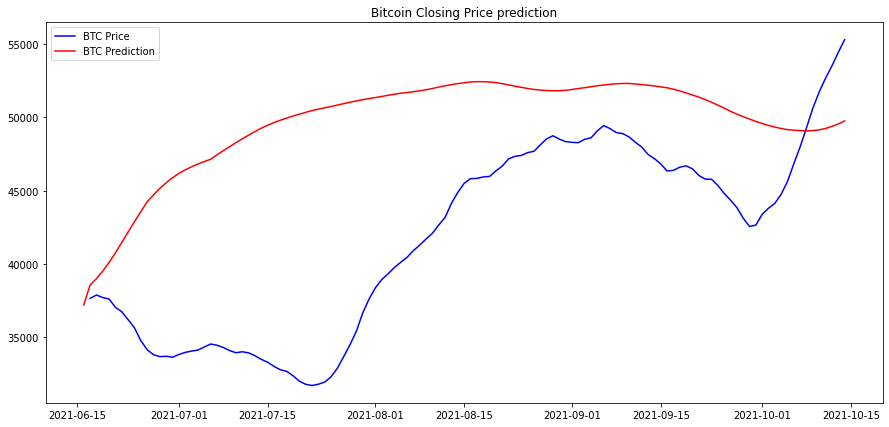

In [68]:
plt.figure(figsize=(15, 7))
plt.plot(date_test, X_test[:, data.columns.get_loc('Close')], color='blue', label='BTC Price')
plt.plot(date_forecast, forecast[:, data.columns.get_loc('Close')], color='red', label='BTC Prediction')
plt.title('Bitcoin Closing Price prediction')
plt.legend()

In [69]:
X_data= data.values
date_train = data.index

X_data = sc.fit_transform(X_data)

train_generator = TimeseriesGenerator(X_data, X_data,  length=n_past)

In [70]:
lstm_model.fit(train_generator, epochs = 5)

Epoch 1/5
20/20 [==============================] - 8s 393ms/step - loss: 0.0063
Epoch 2/5
20/20 [==============================] - 8s 391ms/step - loss: 0.0052
Epoch 3/5
20/20 [==============================] - 9s 467ms/step - loss: 0.0036
Epoch 4/5
20/20 [==============================] - 7s 319ms/step - loss: 0.0028
Epoch 5/5
20/20 [==============================] - 6s 279ms/step - loss: 0.0031


In [71]:
forecast = predict(n_futur, lstm_model)
forecast = sc.inverse_transform(forecast)
X_data = sc.inverse_transform(X_data)
print(X_data.shape)
print(forecast.shape)

date_forecast = predict_dates(n_futur)
date_test = data.index

(2576, 6)
(121, 6)


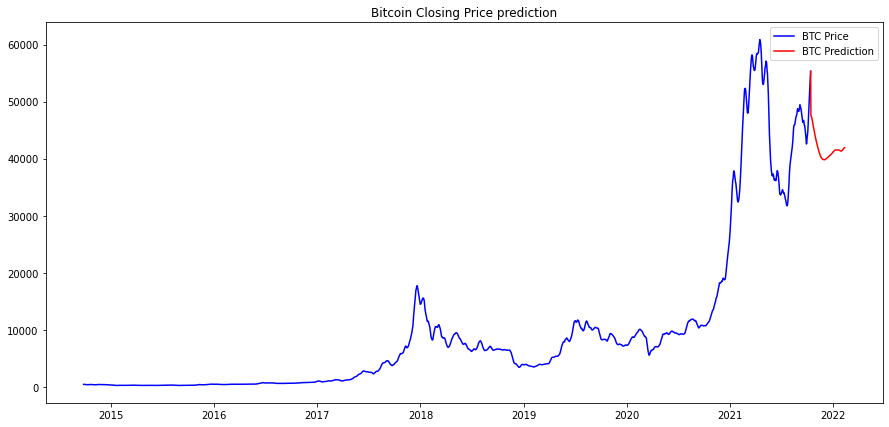

In [72]:
plt.figure(figsize=(15, 7))
plt.plot(date_train, X_data[:, data.columns.get_loc('Close')], color='blue', label='BTC Price')
plt.plot(date_forecast, forecast[:, data.columns.get_loc('Close')], color='red', label='BTC Prediction')
plt.title('Bitcoin Closing Price prediction')
plt.legend()

<h4>Part 2: Prediction on Ethereum (only with Ethereum's features)</h4>

In [79]:
data = pd.read_csv(r'ethereum-price.csv')
data.Date = pd.to_datetime(data.Date)
data = data.set_index('Date')
data = data.fillna(method='backfill')
data = data[::-1]
data = data.rolling(window=window_size, center=False).mean()
data= data.dropna()
data.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2015-08-16,1.413156,1.621044,1.030018,1.251362,2.079956e+06,7.792070e+07
2015-08-17,1.256305,1.474279,1.068053,1.289382,2.224915e+06,7.633894e+07
2015-08-18,1.289678,1.518097,1.113839,1.341564,2.332971e+06,8.191127e+07
2015-08-19,1.345374,1.598442,1.175017,1.417339,2.468671e+06,8.748923e+07
2015-08-20,1.421021,1.640943,1.243974,1.453471,2.660566e+06,9.365187e+07


In [80]:
n_past = 120 #Number of days used to predict
n_futur = 120 #Number of days to predict

sc = MinMaxScaler()
X_data= data[:-n_futur].values
X_test = data[-n_futur:].values
sc.fit(X_data)
X_data = sc.transform(X_data)
print('X_data:', X_data.shape)
print('X_test:', X_test.shape)

train_generator = TimeseriesGenerator(X_data, X_data,  length=n_past, batch_size=BATCH_SIZE)

date_train = data[:-n_futur].index
date_test = data[-n_futur:].index

X_data: (2131, 6)
X_test: (120, 6)


In [81]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True),input_shape=(None, X_data.shape[1])),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=False)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(X_data.shape[1])
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_18 (Bidirectio (None, None, 400)         331200    
_________________________________________________________________
dropout_21 (Dropout)         (None, None, 400)         0         
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 300)               661200    
_________________________________________________________________
dropout_22 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 120)               36120     
_________________________________________________________________
dropout_23 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)                

In [82]:
history = lstm_model.fit(train_generator,epochs=12)

Epoch 1/12
4/4 [==============================] - 10s 1s/step - loss: 0.0120
Epoch 2/12
4/4 [==============================] - 5s 1s/step - loss: 0.0066
Epoch 3/12
4/4 [==============================] - 5s 1s/step - loss: 0.0033
Epoch 4/12
4/4 [==============================] - 5s 1s/step - loss: 0.0055
Epoch 5/12
4/4 [==============================] - 5s 1s/step - loss: 0.0026
Epoch 6/12
4/4 [==============================] - 5s 1s/step - loss: 0.0037
Epoch 7/12
4/4 [==============================] - 5s 1s/step - loss: 0.0035
Epoch 8/12
4/4 [==============================] - 5s 1s/step - loss: 0.0019
Epoch 9/12
4/4 [==============================] - 8s 2s/step - loss: 0.0024
Epoch 10/12
4/4 [==============================] - 5s 1s/step - loss: 0.0018
Epoch 11/12
4/4 [==============================] - 6s 2s/step - loss: 0.0016
Epoch 12/12
4/4 [==============================] - 6s 1s/step - loss: 0.0013


In [83]:
forecast = predict(n_futur, lstm_model)
forecast = sc.inverse_transform(forecast)
print(forecast.shape)

date_forecast = predict_dates(n_futur)

(121, 6)


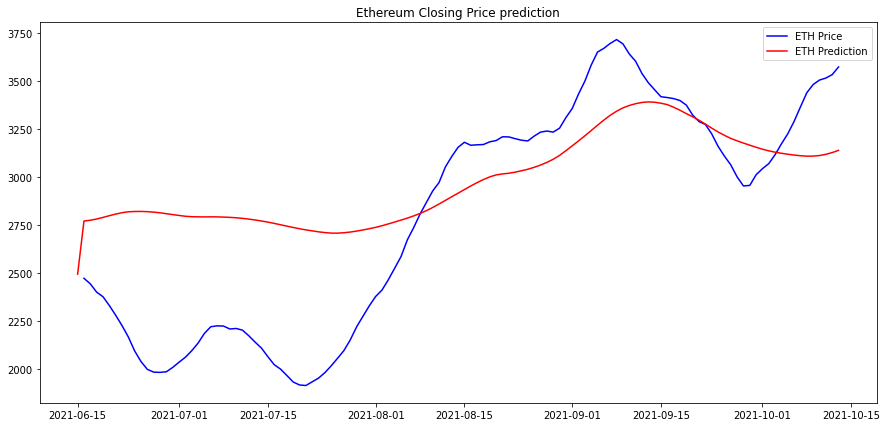

In [84]:
plt.figure(figsize=(15, 7))
plt.plot(date_test, X_test[:, data.columns.get_loc('Close')], color='blue', label='ETH Price')
plt.plot(date_forecast, forecast[:, data.columns.get_loc('Close')], color='red', label='ETH Prediction')
plt.title('Ethereum Closing Price prediction')
plt.legend()

In [20]:
X_data= data.values
date_train = data.index

X_data = sc.fit_transform(X_data)

train_generator = TimeseriesGenerator(X_data, X_data,  length=n_past)

In [21]:
lstm_model.fit(train_generator, epochs = 10)

Epoch 1/15
17/17 [==============================] - 5s 277ms/step - loss: 0.0031
Epoch 2/15
17/17 [==============================] - 5s 276ms/step - loss: 0.0084
Epoch 3/15
17/17 [==============================] - 5s 276ms/step - loss: 0.0283
Epoch 4/15
17/17 [==============================] - 5s 277ms/step - loss: 0.0116
Epoch 5/15
17/17 [==============================] - 5s 277ms/step - loss: 0.0211
Epoch 6/15
17/17 [==============================] - 5s 275ms/step - loss: 0.0086
Epoch 7/15
17/17 [==============================] - 5s 276ms/step - loss: 0.0122
Epoch 8/15
17/17 [==============================] - 5s 276ms/step - loss: 0.0043
Epoch 9/15
17/17 [==============================] - 5s 283ms/step - loss: 0.0026
Epoch 10/15
17/17 [==============================] - 5s 276ms/step - loss: 0.0020TA: 3s 
Epoch 11/15
17/17 [==============================] - 5s 277ms/step - loss: 0.0018
Epoch 12/15
17/17 [==============================] - 5s 276ms/step - loss: 0.0021
Epoch 13/15
17/17 

In [22]:
forecast = predict(n_futur, lstm_model)
forecast = sc.inverse_transform(forecast)
X_data = sc.inverse_transform(X_data)
print(X_data.shape)
print(forecast.shape)

date_forecast = predict_dates(n_futur)

(2251, 6)
(121, 6)


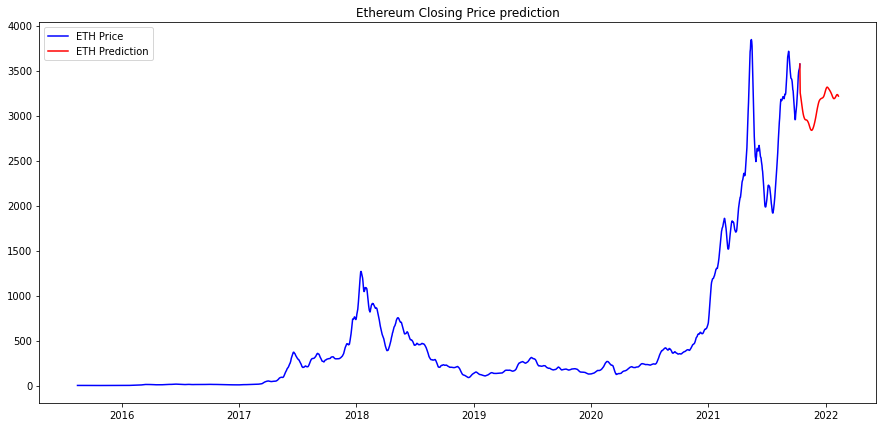

In [23]:
plt.figure(figsize=(15, 7))
plt.plot(date_train, X_data[:, data.columns.get_loc('Close')], color='blue', label='ETH Price')
plt.plot(date_forecast, forecast[:, data.columns.get_loc('Close')], color='red', label='ETH Prediction')
plt.title('Ethereum Closing Price prediction')
plt.legend()

<h4>Part 3: Prediction on both Bitcoin and Ethereum</h4>

We will combine both dataset in this part and try to predict both at the same time (this will fail obviously).

In [24]:
dataBTC = pd.read_csv(r'btc-price.csv')
dataBTC.Date = pd.to_datetime(dataBTC.Date)
dataBTC.drop(columns = ['Adj Close'], inplace=True)
dataETH = pd.read_csv(r'ethereum-price.csv')
dataETH.Date = pd.to_datetime(dataETH.Date)
dataETH.drop(columns = ['Market Cap'], inplace=True)
print(dataETH.head())
data = pd.merge(dataBTC, dataETH, on='Date', how='inner')
data = data.set_index('Date')
data = data.fillna(method='backfill')
data = data.rolling(window=window_size, center=False).mean()
data= data.dropna()
data.head()

        Date         Open         High         Low        Close        Volume
0 2021-10-13  3608.916400  3817.956300  3600.57290  3794.051878  2.467159e+10
1 2021-10-12  3499.203294  3607.459328  3430.69686  3602.466500  2.231418e+10
2 2021-10-11  3542.105961  3543.074443  3418.78420  3494.820215  2.450334e+10
3 2021-10-10  3429.678100  3617.762503  3407.56980  3542.105961  2.611460e+10
4 2021-10-09  3582.206042  3604.313994  3432.53080  3433.770300  2.045228e+10


,Open_x,High_x,Low_x,Close_x,Volume_x,Open_y,High_y,Low_y,Close_y,Volume_y
Date,,,,,,,,,,
2015-08-16,267.772699,269.821899,263.235895,265.671497,30185090.0,1.413156,1.621044,1.030018,1.251362,2.079956e+06
2015-08-17,265.747598,267.833200,261.310995,263.510599,28098400.0,1.256305,1.474279,1.068053,1.289382,2.224915e+06
2015-08-18,263.565997,265.639700,256.347896,258.518797,26459820.0,1.289678,1.518097,1.113839,1.341564,2.332971e+06
2015-08-19,260.021498,262.680301,252.577698,254.678897,30167780.0,1.345374,1.598442,1.175017,1.417339,2.468671e+06
2015-08-20,256.163599,259.713600,249.007997,251.766898,31297340.0,1.421021,1.640943,1.243974,1.453471,2.660566e+06


In [25]:
n_past = 120 #Number of days used to predict
n_futur = 120 #Number of days to predict

sc = MinMaxScaler()
X_data= data[:-n_futur].values
X_test = data[-n_futur:].values
sc.fit(X_data)
X_data = sc.transform(X_data)
print('X_data:', X_data.shape)
print('X_test:', X_test.shape)

train_generator = TimeseriesGenerator(X_data, X_data,  length=n_past, batch_size=BATCH_SIZE)

date_train = data[:-n_futur].index
date_test = data[-n_futur:].index

X_data: (2131, 10)
X_test: (120, 10)


In [26]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True),input_shape=(None, X_data.shape[1])),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=False)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(X_data.shape[1])
])
lstm_model.compile(optimizer='adam', loss='mean_squared_logarithmic_error')
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, None, 400)         337600    
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 400)         0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 400)               961600    
_________________________________________________________________
dropout_6 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               48120     
_________________________________________________________________
dropout_7 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

In [27]:
history = lstm_model.fit(train_generator,epochs=15)

Epoch 1/15
4/4 [==============================] - 10s 1s/step - loss: 0.0102
Epoch 2/15
4/4 [==============================] - 5s 1s/step - loss: 0.0122
Epoch 3/15
4/4 [==============================] - 5s 1s/step - loss: 0.0064
Epoch 4/15
4/4 [==============================] - 5s 1s/step - loss: 0.0052
Epoch 5/15
4/4 [==============================] - 5s 1s/step - loss: 0.0048
Epoch 6/15
4/4 [==============================] - 5s 1s/step - loss: 0.0046
Epoch 7/15
4/4 [==============================] - 5s 1s/step - loss: 0.0032
Epoch 8/15
4/4 [==============================] - 6s 2s/step - loss: 0.0064
Epoch 9/15
4/4 [==============================] - 7s 2s/step - loss: 0.0021
Epoch 10/15
4/4 [==============================] - 8s 2s/step - loss: 0.0022
Epoch 11/15
4/4 [==============================] - 9s 2s/step - loss: 0.0016
Epoch 12/15
4/4 [==============================] - 9s 2s/step - loss: 0.0015
Epoch 13/15
4/4 [==============================] - 7s 1s/step - loss: 0.0012
Epoch 1

In [28]:
forecast = predict(n_futur, lstm_model)
forecast = sc.inverse_transform(forecast)
print(forecast.shape)

date_forecast = predict_dates(n_futur)

(121, 10)


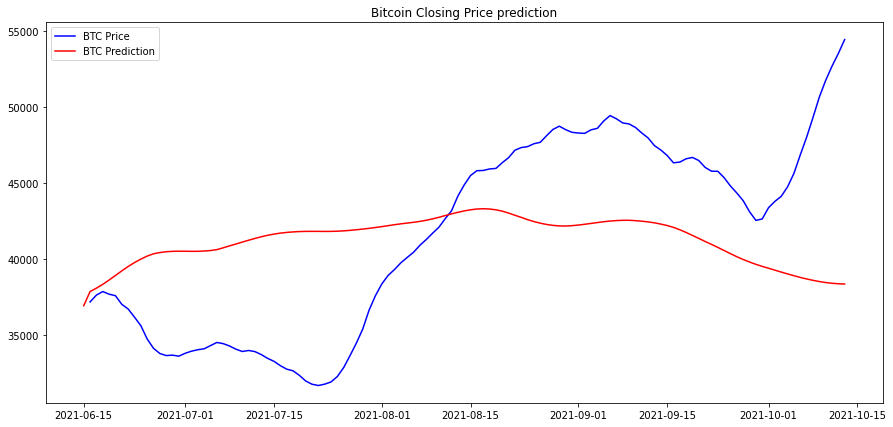

In [29]:
plt.figure(figsize=(15, 7))
plt.plot(date_test, X_test[:, data.columns.get_loc('Close_x')], color='blue', label='BTC Price')
plt.plot(date_forecast, forecast[:, data.columns.get_loc('Close_x')], color='red', label='BTC Prediction')
plt.title('Bitcoin Closing Price prediction')
plt.legend()

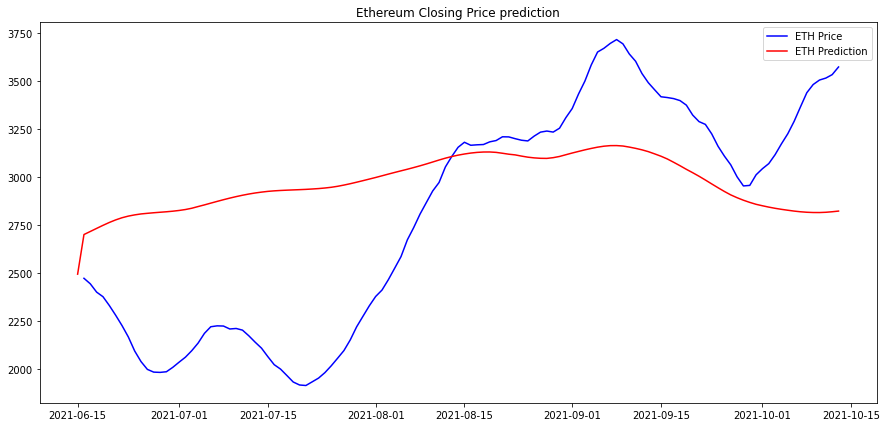

In [30]:
plt.figure(figsize=(15, 7))
plt.plot(date_test, X_test[:, data.columns.get_loc('Close_y')], color='blue', label='ETH Price')
plt.plot(date_forecast, forecast[:, data.columns.get_loc('Close_y')], color='red', label='ETH Prediction')
plt.title('Ethereum Closing Price prediction')
plt.legend()

To conclude:

Well this is too bad to predict the next 6 months...

This is because there are too many features and the loss isn't adapted for this kind of problem.
We should look at transformers and attention mechanism in a futur notebook to solve these problems.